<a href="https://colab.research.google.com/github/tmsk0711/GoingDeeper/blob/main/4_ResNet_Augemtation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds



In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete95V200/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete95V200/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


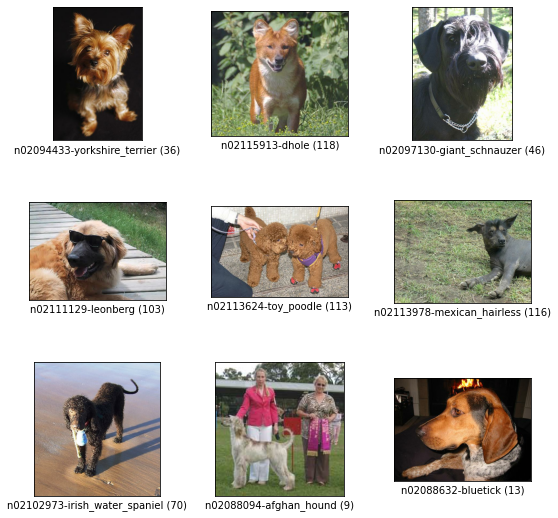

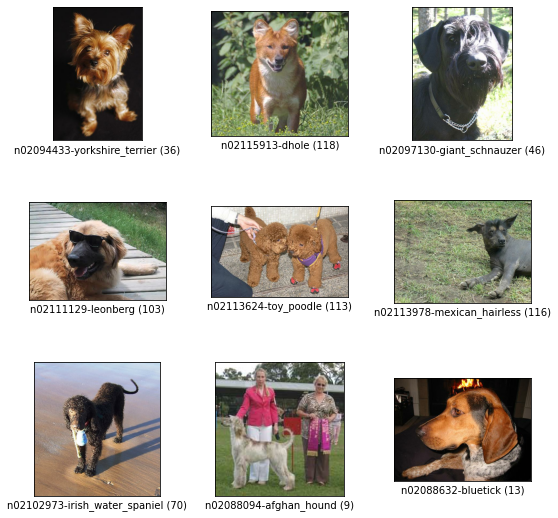

In [5]:
tfds.show_examples(ds_train, ds_info)

# Augmentation 적용

In [37]:
# 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


 >입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용

In [7]:
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image, 0,1)
  return image,label

> * random_flip_left_right()과 random_brightness()를 활용
* 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용X
* "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls = 2
  )

  if not is_test and with_aug: # both True
    ds = ds.map(
        augment, # augment function
        num_parallel_calls = 2 
    )

  ds = ds.batch(batch_size)
    
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
  return ds


> * num_parallel_calls? 뭐하는건지 궁금해졌다.
map의 매개변수, 여러개의 스레드를 나누어서 속도를 높여 처리 가능( 개쩌는 매개변수)


---
> * 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset()로 정의
* 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용
* 코드에서는 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정

In [41]:
# make random augment function
def augment2(image,label):
    image = tf.random.uniform([1], minval=range[0], maxval=range[1])
    image = tf.image.resize(image, [224,224])

    return image, label

# Augmentation 적용 후 비교실험 

In [42]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
  keras.applications.resnet.ResNet50(
      include_top = False,
      weights = 'imagenet',
      input_shape=(224,224,3),
      pooling='avg',
  ),
  keras.layers.Dense(num_classes, activation='softmax')
])

> * ResNet50 중 imagenet으로 훈련된 모델을 불러온다.
* include_top은 마지막 fully connected layer를 포함할지 여부
* 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용
* 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문

In [32]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


In [33]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [43]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 169s 200ms/step - loss: 2.2313 - accuracy: 0.4411 - val_loss: 3.3380 - val_accuracy: 0.2232
Epoch 2/3
750/750 [==============================] - 152s 203ms/step - loss: 0.6752 - accuracy: 0.8213 - val_loss: 1.1081 - val_accuracy: 0.6735
Epoch 3/3
750/750 [==============================] - 154s 205ms/step - loss: 0.1910 - accuracy: 0.9653 - val_loss: 0.9320 - val_accuracy: 0.7235


In [44]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 159s 200ms/step - loss: 2.2854 - accuracy: 0.4342 - val_loss: 2.9428 - val_accuracy: 0.2800
Epoch 2/3
750/750 [==============================] - 153s 203ms/step - loss: 0.9751 - accuracy: 0.7254 - val_loss: 1.3283 - val_accuracy: 0.6222
Epoch 3/3
750/750 [==============================] - 153s 205ms/step - loss: 0.5110 - accuracy: 0.8579 - val_loss: 1.2218 - val_accuracy: 0.6533


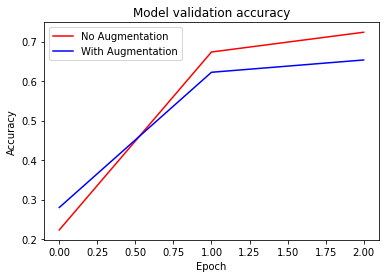

In [45]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

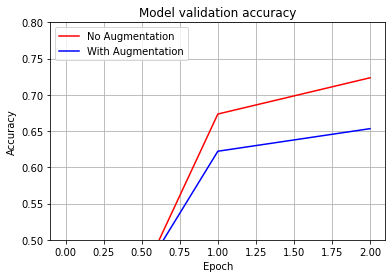

In [47]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# Cutmix augmentation
https://arxiv.org/pdf/1905.04899.pdf
https://www.kaggle.com/code/cdeotte/cutmix-and-mixup-on-gpu-tpu/notebook\
> * Mixup은 특정 비율로 픽셀별 값을 섞는 방식
* Cutout은 이미지를 잘라내는 방식입니다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법

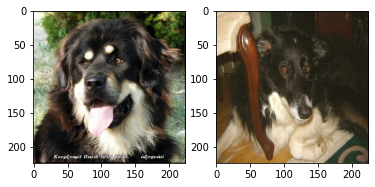

In [48]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [51]:
print(image_a.shape)
# image.shape = (height, width, channel)
def get_clip_box(image_a, image_b):
  image_size_x = image_a.shape[1]
  iamge_size_y = iamge_a.shape[0]

  # get center of box
  x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
  y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

  

(224, 224, 3)
